# Plot results

In [1]:
import pandas as pd
import geopandas as gpd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib.gridspec as gridspec

In [2]:
city_two_layer_network_edges = gpd.read_file("./city_two_layer_network_edges20250904.GPKG")
connect_edges_sub_to_tram = gpd.read_file("./connect_edges_sub_to_tram20250904.GPKG")

In [3]:
with open("all_objects_grid1.pkl", "rb") as f:
    loaded = pickle.load(f)

grid_1 = loaded["gdf"]
scl_each_disrupted_grid_1 = loaded["df"]
removed_edges_df_dict_1 = loaded["dict"]

In [4]:
with open("all_objects_grid2.pkl", "rb") as f:
    loaded = pickle.load(f)

grid_2 = loaded["gdf"]
scl_each_disrupted_grid_2 = loaded["df"]
removed_edges_df_dict_2 = loaded["dict"]

In [5]:
def plot_disrupted_edges_in_grid(
    grid, 
    scl_each_disrupted_grid, 
    city_two_layer_network_edges, 
    removed_edges_df_dict, 
    connect_edges_sub_to_tram,
    plot_title, 
    grid_nums,
    bbox
):
    """
    Plot disruption scenarios for specified Grid_num values within a user-defined bounding box,
    overlayed on a satellite basemap.

    Parameters
    ----------
    grid : GeoDataFrame
        Grid polygons.
    scl_each_disrupted_grid : GeoDataFrame
        (Unused here but kept for compatibility).
    city_two_layer_network_edges : GeoDataFrame
        Full network edges (metro, tram, etc.).
    removed_edges_df_dict : dict
        Dictionary mapping grid_num -> disrupted edges GeoDataFrame.
    connect_edges_sub_to_tram : GeoDataFrame
        Intermodal transfer edges (e.g., metro-tram).
    plot_title : str
        Title for the overall figure.
    grid_nums : list[int] or int
        Grid IDs to plot (single int or list of ints).
    bbox : dict
        Bounding box for plotting, format:
        {
            "minx": float,
            "maxx": float,
            "miny": float,
            "maxy": float
        }

    Returns
    -------
    None
        Saves a PNG file and displays the figure.
    """


    # Ensure grid_nums is a list
    if isinstance(grid_nums, int):
        grid_nums = [grid_nums]

    # Load CRS from metro lines dataset
    metro_lines = gpd.read_file("./Metro lines.GPKG")

    num_plots = len(grid_nums)
    fig = plt.figure(figsize=(10, 8 * num_plots))
    gs = gridspec.GridSpec(num_plots, 1)

    plt.rcParams.update({'font.size': 20})

    axes = []
    for i, grid_num in enumerate(grid_nums):
        ax = fig.add_subplot(gs[i, 0])
        axes.append(ax)

        # --- Filter input layers to bounding box ---
        city_edges_gdf = gpd.GeoDataFrame(city_two_layer_network_edges.copy(),
                                          geometry='geometry', crs=metro_lines.crs)
        city_edges_gdf = city_edges_gdf.cx[bbox["minx"]:bbox["maxx"], bbox["miny"]:bbox["maxy"]]

        removed_edges_gdf = gpd.GeoDataFrame(removed_edges_df_dict[grid_num].copy(),
                                             geometry='geometry', crs=metro_lines.crs)
        removed_edges_gdf = removed_edges_gdf.cx[bbox["minx"]:bbox["maxx"], bbox["miny"]:bbox["maxy"]]

        intermodal_transfer_gdf = gpd.GeoDataFrame(connect_edges_sub_to_tram.copy(),
                                                   geometry='geometry', crs=metro_lines.crs)
        intermodal_transfer_gdf = intermodal_transfer_gdf.cx[bbox["minx"]:bbox["maxx"], bbox["miny"]:bbox["maxy"]]

        grid_gdf = gpd.GeoDataFrame(grid.loc[grid.index == grid_num].copy(),
                                    geometry='geometry', crs=metro_lines.crs)
        grid_gdf = grid_gdf.cx[bbox["minx"]:bbox["maxx"], bbox["miny"]:bbox["maxy"]]

        # Restrict intermodal transfer edges to grid area only
        if not grid_gdf.empty:
            intermodal_transfer_gdf = gpd.overlay(intermodal_transfer_gdf, grid_gdf, how='intersection')

        # Avoid duplicating edges if IDs overlap
        if not intermodal_transfer_gdf.empty and "id" in removed_edges_gdf.columns and "id" in intermodal_transfer_gdf.columns:
            removed_edges_gdf = removed_edges_gdf[~removed_edges_gdf["id"].isin(intermodal_transfer_gdf["id"])]

        # --- Plotting ---
        # Base network
        city_edges_gdf.plot(ax=ax, color='grey', linewidth=2.5, alpha=0.4)

        # Disrupted edges: solid dark blue
        if not removed_edges_gdf.empty:
            removed_edges_gdf.plot(
                ax=ax,
                linewidth=3.5,
                linestyle='-',
                color='#045a8d' ###'#5299cc'   
            )

        # Intermodal transfer edges: dotted cyan
        if not intermodal_transfer_gdf.empty:
            intermodal_transfer_gdf.plot(
                ax=ax,
                linewidth=3.5,
                # linestyle=':',
                color='#74a9cf'   ###'#95aeda'
            )

        # Grid boundary: dashed orange
        grid_gdf.boundary.plot(
            ax=ax,
            # edgecolor='#fecc5c',  ###'#fcd590',
            edgecolor='#ffa000',
            linewidth=5,
            linestyle='--'
            # alpha=0.9
        )

        # Add basemap
        ctx.add_basemap(ax=ax, crs=metro_lines.crs.to_string(),
                        source=ctx.providers.Esri.WorldImagery, alpha=0.4, attribution=False)

        # Clean up ticks
        ax.set_xticks([])
        ax.set_yticks([])

        # Subplot title
        # ax.set_title(f"Grid {grid_num}", fontsize=24, pad=10)

    # Overall title
    # fig.suptitle(plot_title, fontsize=28, y=0.995)
    plt.tight_layout(rect=[0, 0, 1, 0.97])  

    # Save & show
    plt.savefig(f"{plot_title}.png", bbox_inches='tight', dpi=600)
    plt.show()

In [6]:
bbox_central = {"minx": 4.882, "maxx": 4.892, "miny": 52.352, "maxy": 52.362}

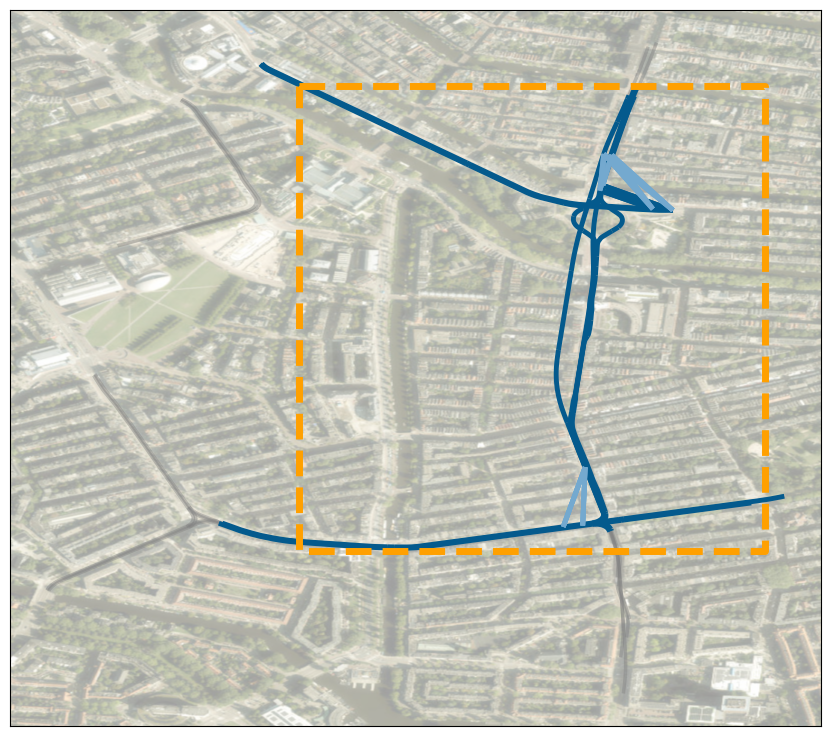

In [7]:
plot_disrupted_edges_in_grid(grid_1, scl_each_disrupted_grid_1, city_two_layer_network_edges, removed_edges_df_dict_1, connect_edges_sub_to_tram,
                               "Removed_edges_Dis2_in_grid_147",[147], bbox_central)

In [8]:
bbox_central = {"minx": 4.876, "maxx": 4.894, "miny": 52.341, "maxy": 52.365}

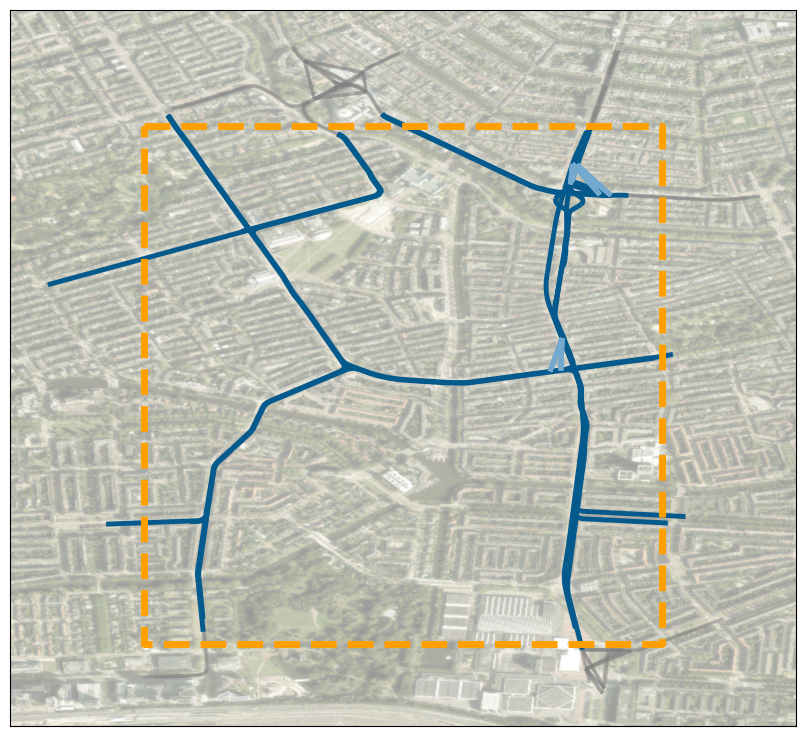

In [9]:
plot_disrupted_edges_in_grid(grid_2, scl_each_disrupted_grid_2, city_two_layer_network_edges, removed_edges_df_dict_2, connect_edges_sub_to_tram,
                               "Removed_edges_Dis2_in_grid_37",[37], bbox_central)

In [10]:
## Plot bar charts 20250904

In [11]:
scl_grid_1 = pd.read_excel('./scl_grid_1.xlsx')
scl_no_links_grid_1 = pd.read_excel('./scl_no_links_grid_1.xlsx')
dwcl_grid_1 = pd.read_excel('./dwcl_grid_1.xlsx')
dwcl_no_links_grid_1 = pd.read_excel('./dwcl_no_links_grid_1.xlsx')

In [12]:
scl_grid_1['transfer'] = 'With transfer'
dwcl_grid_1['transfer'] = 'With transfer'
scl_no_links_grid_1['transfer'] = 'Without transfer'
dwcl_no_links_grid_1['transfer'] = 'Without transfer'

In [13]:
scl_147 = pd.concat((scl_grid_1[scl_grid_1["Grid_num"]==147],scl_no_links_grid_1[scl_no_links_grid_1["Grid_num"]==147]))

In [14]:
scl_147

,simple_connectivity_loss,Grid_num,transfer
59,0.000000,147,With transfer
59,0.394126,147,Without transfer


In [15]:
dwcl_147 = pd.concat((dwcl_grid_1[dwcl_grid_1["Grid_num"]==147],dwcl_no_links_grid_1[dwcl_no_links_grid_1["Grid_num"]==147]))

In [16]:
dwcl_147

,Grid_num,DWCL_weights,transfer
59,147,0.219083,With transfer
59,147,0.591757,Without transfer


In [17]:
scl_long = scl_147.rename(columns={"simple_connectivity_loss": "value"})
scl_long["metric"] = "SCL"

dwcl_long = dwcl_147.rename(columns={"DWCL_weights": "value"})
dwcl_long["metric"] = "DWCL"

df_long_147 = pd.concat([
    scl_long[["Grid_num", "value", "metric", "transfer"]],
    dwcl_long[["Grid_num", "value", "metric", "transfer"]]
])

df_long_147["row_id"] = df_long_147.groupby("metric").cumcount()

In [18]:
df_long_147

,Grid_num,value,metric,transfer,row_id
59,147,0.000000,SCL,With transfer,0
59,147,0.394126,SCL,Without transfer,1
59,147,0.219083,DWCL,With transfer,0
59,147,0.591757,DWCL,Without transfer,1


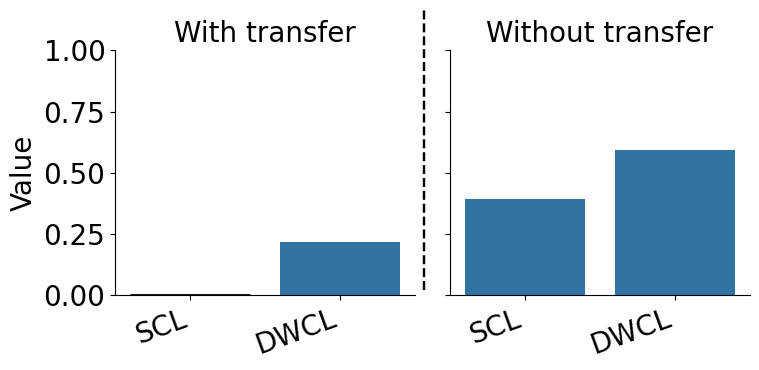

In [19]:
# ---- FacetGrid plot ----
g = sns.FacetGrid(df_long_147, col="transfer", height=4, aspect=1, sharey=True)
g.map_dataframe(sns.barplot, x="metric", y="value", order=["SCL", "DWCL"], errorbar=None)

# Set y-axis range and ticks
g.set(ylim=(0, 1))
g.set(yticks=[0, 0.25, 0.5, 0.75, 1])
g.set_xlabels("")
g.set_ylabels("Value")
g.set_titles("{col_name}")

# Set x tick labels
for ax in g.axes.flat:
    ax.set_xticks([0, 1])  # Explicitly specify two tick positions
    ax.set_xticklabels(["SCL", "DWCL"], rotation=20, ha="right")
    
# Highlight the first bar of the first subplot on the left
first_ax = g.axes[0, 0]
bars = first_ax.patches
if bars:
    bars[0].set_edgecolor("black")
    bars[0].set_linewidth(2)

# ---- Add a vertical dashed line between the two subplots ----
# Get figure and subplot coordinates
fig = g.fig
ax_left, ax_right = g.axes.flat

# Get subplot boundaries in figure coordinates
bbox_left = ax_left.get_position()
bbox_right = ax_right.get_position()

# Calculate the x-position of the split line (midpoint between two subplots)
x_split = (bbox_left.x1 + bbox_right.x0) / 2

# Draw a vertical dashed line in figure coordinates
fig.add_artist(plt.Line2D(
    [x_split, x_split], [0.25, 0.95],  # y range covering subplots
    color="black", linestyle="--", linewidth=1.75, transform=fig.transFigure
))

# ---- Adjust subplot spacing ----
g.fig.subplots_adjust(wspace=0.05)

plt.tight_layout()
plt.savefig("transfer_scl_dwcl_vline_147.png", bbox_inches='tight', dpi=600)
plt.show()

In [20]:
scl_grid_2 = pd.read_excel('./scl_grid_2.xlsx')
scl_no_links_grid_2 = pd.read_excel('./scl_no_links_grid_2.xlsx')
dwcl_grid_2 = pd.read_excel('./dwcl_grid_2.xlsx')
dwcl_no_links_grid_2 = pd.read_excel('./dwcl_no_links_grid_2.xlsx')

In [21]:
scl_grid_2['transfer'] = 'With transfer'
dwcl_grid_2['transfer'] = 'With transfer'
scl_no_links_grid_2['transfer'] = 'Without transfer'
dwcl_no_links_grid_2['transfer'] = 'Without transfer'

In [22]:
scl_37 = pd.concat((scl_grid_2[scl_grid_2["Grid_num"]==37],scl_no_links_grid_2[scl_no_links_grid_2["Grid_num"]==37]))

In [23]:
dwcl_37 = pd.concat((dwcl_grid_2[dwcl_grid_2["Grid_num"]==37],dwcl_no_links_grid_2[dwcl_no_links_grid_2["Grid_num"]==37]))

In [24]:
scl_long = scl_37.rename(columns={"simple_connectivity_loss": "value"})
scl_long["metric"] = "SCL"

dwcl_long = dwcl_37.rename(columns={"DWCL_weights": "value"})
dwcl_long["metric"] = "DWCL"

df_long_37 = pd.concat([
    scl_long[["Grid_num", "value", "metric", "transfer"]],
    dwcl_long[["Grid_num", "value", "metric", "transfer"]]
])

df_long_37["row_id"] = df_long_37.groupby("metric").cumcount()

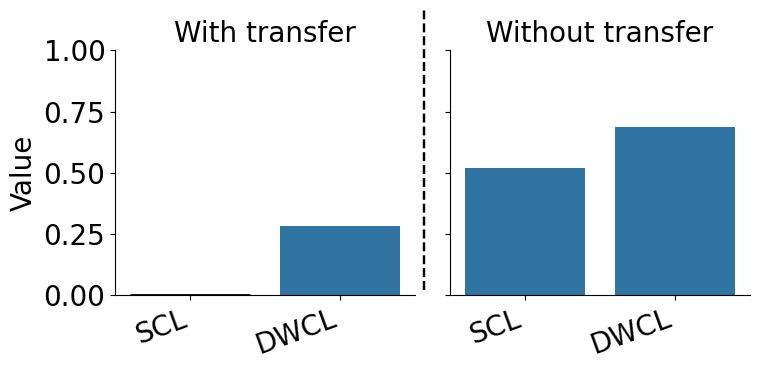

In [25]:
# ---- FacetGrid plot ----
g = sns.FacetGrid(df_long_37, col="transfer", height=4, aspect=1, sharey=True)
g.map_dataframe(sns.barplot, x="metric", y="value", order=["SCL", "DWCL"], errorbar=None)

# Set y-axis range and ticks
g.set(ylim=(0, 1))
g.set(yticks=[0, 0.25, 0.5, 0.75, 1])
g.set_xlabels("")
g.set_ylabels("Value")
g.set_titles("{col_name}")

# Set x tick labels
for ax in g.axes.flat:
    ax.set_xticks([0, 1])  # Explicitly specify two tick positions
    ax.set_xticklabels(["SCL", "DWCL"], rotation=20, ha="right")

# Highlight the first bar of the first subplot on the left
first_ax = g.axes[0, 0]
bars = first_ax.patches
if bars:
    bars[0].set_edgecolor("black")
    bars[0].set_linewidth(2)

# ---- Add a vertical dashed line between the two subplots ----
# Get figure and subplot coordinates
fig = g.fig
ax_left, ax_right = g.axes.flat

# Get subplot boundaries in figure coordinates
bbox_left = ax_left.get_position()
bbox_right = ax_right.get_position()

# Calculate the x-position of the split line (midpoint between two subplots)
x_split = (bbox_left.x1 + bbox_right.x0) / 2

# Draw a vertical dashed line in figure coordinates
fig.add_artist(plt.Line2D(
    [x_split, x_split], [0.25, 0.95],  # y range covering subplots
    color="black", linestyle="--", linewidth=1.75, transform=fig.transFigure
))

# ---- Adjust subplot spacing ----
g.fig.subplots_adjust(wspace=0.05)

plt.tight_layout()
plt.savefig("transfer_scl_dwcl_vline_37.png", bbox_inches='tight', dpi=600)
plt.show()